[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/KaggleProj)

# Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.axes_style("whitegrid")

from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler, binarize, label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, plot_roc_curve, confusion_matrix, classification_report, precision_recall_curve, average_precision_score  
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_validate

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

# Const And Global Vars

In [2]:
CORES = 3
model_dict = {}

# Declare funcs

In [3]:
def paint():
    tmp = train_df.groupby('label').sum()
    train_data = np.array(tmp, dtype='float32')

    first_image = train_data[0]

    first_image = np.array(first_image, dtype='uint8')
    pixels = first_image.reshape((28, 28))
    import numpy as np; np.random.seed(0)

    import seaborn as sns; sns.set()

    # uniform_data = np.random.rand(10, 12)
    uniform_data = pixels#//500
    ax = sns.heatmap(uniform_data)

    uniform_data.max()

In [4]:
def evaluate(true, pred, plot=False):
#     model_accuracy = roc_auc_score(true, pred, multi_class="ovr")
#     null_accuracy = roc_auc_score(true, true.replace(1, 0))
    
#     print("Null AUC Score: {:.5f}".format(null_accuracy))
#     print("Model AUC Score: {:.5f}".format(model_accuracy))

#     if null_accuracy >= model_accuracy:
#         print("The model isn't effective")
# #         return
#     else:
#         print("The model is better then a 'dumb' model")
    print("confusion_matrix:\n", confusion_matrix(true, pred))
    print(classification_report(true, pred))
    if plot:
        plot_scores(true, pred)

In [5]:
def plot_scores(true, pred):
    from sklearn.metrics import precision_score, recall_score, f1_score
    labels = np.unique(true)

    ytest = label_binarize(true, classes=labels)
    ypreds = label_binarize(pred, classes=labels)

    n_classes = len(labels)
    f1_scores = dict()
    accuracy_scores = dict()
    for i in range(n_classes):
        f1_scores[i] = f1_score(ytest[:, i], ypreds[:, i], average='weighted')
        accuracy_scores[i] = accuracy_score(ytest[:, i], ypreds[:, i])
        plt.scatter(f1_scores[i], accuracy_scores[i], lw=2, label='class {}'.format(i))
#         plt.plot(f1_scores[i], accuracy_scores[i], lw=2, label='class {}'.format(i))
#     precision = dict()
#     recall = dict()
#     for i in range(n_classes):
#         precision[i] = precision_score(ytest[:, i], ypreds[:, i], average='weighted')
#         recall[i] = recall_score(ytest[:, i], ypreds[:, i], average='weighted')


    x = list(f1_scores.values())
    y = list(accuracy_scores.values())
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--")
    print("y=%.6fx+(%.6f)"%(z[0],z[1]))
    
    plt.xlabel("f1_scores")
    plt.ylabel("accuracy_scores")
    plt.legend(loc="best")
    plt.title("f1_scores vs. accuracy_scores")
    plt.show()
    print(labels)
    print(accuracy_scores)
    print(f1_scores)
    return f1_scores

In [6]:
def score_models(model, model_scores):
    model_dict.update({model: model_scores})

    print("Accuracy: {:.2f} (+/- {:.2f})".format(model_scores['test_score'].mean(), model_scores['test_score'].std() * 2))
    print('Train time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['fit_time'].mean(), model_scores['fit_time'].std() * 2, model_scores['fit_time'].sum()))
    print('Test time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['score_time'].mean(), model_scores['score_time'].std() * 2, model_scores['score_time'].sum()))

In [7]:
def find_best_model():
    max_score = 0
    best_key = None
    for key in model_dict:
        model_score=model_dict[key]['test_score'].mean()
#         model_score = model_dict[key].mean()
#         try:   
#             model_score=model_dict[key]['test_score'].mean()
#         except IndexError: # remove this
#             model_score=model_dict[key].mean()
        if max_score < model_score:
            max_score = model_score
            best_key = key
    best_model_name = best_key
    print('the best model is {}'.format(best_key).split('(')[0], end = ' ')
    print('with the score of {}'.format(max_score))
    return best_key, max_score

---
# Data preparation

## load data

In [8]:
train_df = pd.read_csv('data/fashion-mnist_train.csv')
test_df = pd.read_csv('data/fashion-mnist_test.csv')

In [9]:
train_df.head()
train_df.isnull().sum().unique()

array([0], dtype=int64)

0 is t shirt\
1 is trousers\
2 is pullover\
3 is dress\
4 is coat\
5 is sandals\
6 is shirt\
7 is sneaker\
8 is bag\
9 is ankle boots

In [10]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [11]:
train_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


## split the training data into train and validate

In [12]:
train_data = np.array(train_df, dtype='float32')
test_data = np.array(test_df, dtype='float32')

X_train = train_data[:, 1:] / 1
y_train = train_data[:, 0]

X_test = test_data[:, 1:] / 1#/128#/255
y_test = test_data[:, 0]

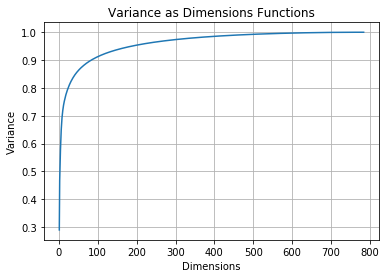

In [13]:
pca = PCA(random_state=0)
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
x = np.arange(1, len(cumsum)+1)
plt.plot(x, cumsum)
plt.grid(True)
plt.title('Variance as Dimensions Functions')
plt.xlabel('Dimensions')
plt.ylabel('Variance')
plt.show()

In [14]:
pca = PCA(random_state=0, n_components=0.90)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
d = len(pca.singular_values_)
print('the number of vectors after pca is {}'.format(d))

the number of vectors after pca is 84


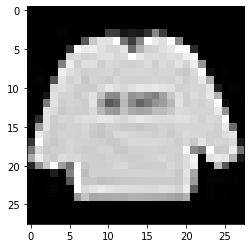

In [15]:
first_image = X_train[0]

first_image = np.array(first_image, dtype='uint8')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

---
# Models

## Run The Models

### Naive Bayes

In [ ]:
gnb = GaussianNB()

# gnb.fit(X_train_pca, y_train)
# predictions = gnb.predict(X_test_pca)
# evaluate(y_test, predictions)

gnb_scores = cross_validate(gnb, X_train_pca, y_train, cv=10)
score_models(gnb, gnb_scores)

pred = cross_val_predict(gnb, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

Accuracy: 0.77 (+/- 0.01)
Train time: 0.07 seconds (+/- 0.01) for a total of 0.74 seconds
Test time: 0.08 seconds (+/- 0.01) for a total of 0.80 seconds


In [ ]:
# mnb = MultinomialNB()
# mnb.fit(X_train_pca, y_train)
# predictions = mnb.predict(X_test_pca)
# evaluate(y_test, predictions)

### Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=0, max_depth=None, n_estimators=100, n_jobs=CORES)

# scores = cross_val_score(rf, X_train_pca, y_train, cv=10, scoring='neg_mean_squared_error')
# rf_score = np.sqrt(-scores)
rf_scores = cross_validate(rf, X_train_pca, y_train, cv=10, n_jobs=CORES)

# model_dict.update({"RandomForestClassifier": rf_score})

# print("Accuracy: %0.2f (+/- %0.2f)" % (rf_score.mean(), rf_score.std() * 2))

score_models(rf, rf_scores)

pred = cross_val_predict(rf, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

### KNN

In [ ]:
#now lets find the optimum K 
k_max = 15
k_min = 1
err_rate = []
for i in range(k_min, k_max+1):
    k = KNeighborsClassifier(n_neighbors=i, n_jobs=CORES)
#     k.fit(X_train_pca, y_train)
#     pred_i = k.predict(X_test_pca)
#     err_rate.append(np.mean(pred_i != y_test))
    scores = cross_validate(k, X_train_pca, y_train, cv=10, n_jobs=CORES)['test_score']
    if scores.std() > 0.5:
        err_rate.append(0)
    else:
        err_rate.append(scores.mean())

In [ ]:
plt.plot(np.arange(k_min, k_max+1), err_rate)
plt.show()

In [ ]:
index = err_rate.index(max(err_rate)) + 1
index

In [ ]:
k = KNeighborsClassifier(n_neighbors=index, n_jobs=CORES)
k_scores = cross_validate(k, X_train_pca, y_train, cv=10, n_jobs=CORES)
score_models(k, k_scores)

pred = cross_val_predict(k, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

### Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=0, n_jobs=CORES)#, solver='lbfgs', penalty='l2')
lr_scores = cross_validate(lr, X_train_pca, y_train, cv=10, n_jobs=CORES)
score_models(lr, lr_scores)

pred = cross_val_predict(lr, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

### SVM

#### SVC

In [ ]:
svc = SVC(random_state=0, max_iter=500)

svc_scores = cross_validate(svc, X_train_pca, y_train, cv=10, n_jobs=CORES)
score_models(svc, svc_scores)

pred = cross_val_predict(svc, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

### Decision Tree

In [ ]:
dtc = DecisionTreeClassifier(random_state=0)
dtc_scores = cross_validate(dtc, X_train_pca, y_train, cv=10, n_jobs=CORES)
score_models(dtc, dtc_scores)

pred = cross_val_predict(dtc, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

### Gradient Boosting

In [ ]:
# gb = GradientBoostingClassifier(random_state=0)
# gb_scores = cross_validate(gb, X_train_pca, y_train, cv=10, n_jobs=CORES)
# score_models(gb, gb_scores)

# pred = cross_val_predict(gb, X_train_pca, y_train, cv=10, n_jobs=CORES)
# evaluate(y_train, pred, plot=True)

## Find Best Model

In [ ]:
best_model, best_model_score = find_best_model()

## Improve The Model

### Ada Boost

In [ ]:
base_estimetor = best_model
adb = AdaBoostClassifier(base_estimetor, random_state=0)
adb_scores = cross_validate(adb, X_train_pca, y_train, cv=10, n_jobs=CORES)

pred = cross_val_predict(adb_scores, X_train_pca, y_train, cv=10, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

#### check if the model was improved

In [ ]:
if adb_scores['test_score'].mean() > best_model_score:
    best_model = adb

## Test The Model On The Test Data

In [ ]:
best_model.fit(X_train_pca, y_train)
predictions = best_model.predict(X_test_pca)
evaluate(y_test, predictions, plot=True)

### run without pca

In [ ]:
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)
evaluate(y_test, predictions)

In [ ]:
# from sklearn.preprocessing import label_binarize

# labels = [0, 1, 2, 3,4,5,6,7,8,9]
# ytest = label_binarize(y_test, classes=labels)
# ypreds = label_binarize(predictions, classes=labels)

# roc_auc_score(ytest, ypreds, average='macro',multi_class='ovo')
# # plot_roc_curve(best_model, X_test_pca, y_test)

In [ ]:
# # precision recall curve
# # precision = dict()
# # recall = dict()
# # for i in range(n_classes):
# #     precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
# #                                                         y_score[:, i]))
# #     plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
# n_classes = len(labels)
# roc_scores = [0, 1, 2, 3,4,5,6,7,8,9]
# for i in range(n_classes):
#     roc_scores[i] = roc_auc_score(ytest[:, i], ypreds[:, i], average='macro',multi_class='ovo')
#     plt.scatter(labels[i], roc_scores[i], lw=2, label='class {}'.format(i))

# # plt.plot(labels, roc_scores, lw=2, label='class {}'.format(i))
# plt.xlabel("recall")
# plt.ylabel("precision")
# plt.legend(loc="best")
# plt.title("precision vs. recall curve")
# plt.show()

# for i in range(n_classes):
#     print('{} {}'.format(labels[i], roc_scores[i]))

In [ ]:
# gnb = GaussianNB()
# # 
# # gnb.fit(X_train_pca, y_train)
# # predictions = gnb.predict(X_test_pca)
# # evaluate(y_test, predictions)

# gnb_scores = cross_validate(gnb, X_train_pca, y_train, cv=10)
# score_models('GaussianNB', gnb_scores)

# pred = cross_val_predict(gnb, X_train_pca, y_train, cv=10, n_jobs=CORES)

# print(accuracy_score(y_train, pred))

# evaluate(y_train, pred, plot=True)
# # print(f1_score(y_train, pred, average='macro'))

# # tmp = plot_scores(y_train, pred)
# # tmp

In [ ]:
# evaluate(y_test, predictions)

# ytest = label_binarize(y_test, classes=labels)
# ypreds = label_binarize(predictions, classes=labels)

# # scoring = 'average_precision'
# fpr, tpr, thresholds = roc_curve(ytest, ypreds)
# scores = []
# for x in thresholds:
#     predictions_class = binarize([predictions], x)[0]
#     scores.append(average_precision_score(y_test, predictions_class))
# scores = np.array(scores)
# index = np.argmax(scores) 


# scores = []
# thresholds = np.arange(0, 1, 0.01)
# for x in thresholds:
#     predictions_class = binarize([predictions], x)[0]
#     scores.append(accuracy_score(y_test, predictions_class))
# scores = np.array(scores)
# index = np.argmax(scores) 
# predictions_class = binarize([predictions], thresholds[index])[0]
# evaluate(y_test, predictions_class)


# thresholds[index]
# predictions
# # binarize([predictions], 0.5)[0]
# y_test

In [ ]:
# ### Predict test_y values and probabilities based on fitted logistic 
# # regression model

# pred_y=best_model.predict(X_test_pca) 
# # pred_y = predictions

# probs_y=best_model.predict_proba(X_test_pca) 
# #   # probs_y is a 2-D array of probability of being labeled as 0 (first 
# #   column of 
# #   array) vs 1 (2nd column in array)

# from sklearn.metrics import precision_recall_curve
# precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 
# 1]) 
#    #retrieve probability of being 1(in second column of probs_y)
# pr_auc = metrics.auc(recall, precision)

# plt.title("Precision-Recall vs Threshold Chart")
# plt.plot(thresholds, precision[: -1], "b--", label="Precision")
# plt.plot(thresholds, recall[: -1], "r--", label="Recall")
# plt.ylabel("Precision, Recall")
# plt.xlabel("Threshold")
# plt.legend(loc="lower left")
# plt.ylim([0,1])